In [1]:
import lightning as L
from lightning.pytorch.callbacks import RichProgressBar
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme

from bridges import AbsorbingBridgeMatching
from utils import DataloaderModule
from jetdata import JetDataclass

progress_bar = RichProgressBar(
    theme=RichProgressBarTheme(
        description="green_yellow",
        progress_bar="green1",
        progress_bar_finished="green1",
        progress_bar_pulse="#6206E0",
        batch_progress="green_yellow",
        time="grey82",
        processing_speed="grey82",
        metrics="grey82",
        metrics_text_delimiter="\n",
        metrics_format=".3e",
    )
)

In [2]:

path = "/home/df630/Multimodal-Bridges/lightning_logs/version_68"
ckpt = "/checkpoints/epoch=99-step=5600.ckpt"

abm = AbsorbingBridgeMatching.load_from_checkpoint(path + ckpt)

config = abm.hparams.config
config.experiment.work_dir = path
config.experiment.run_name = "aoj_generation"
config.data.target.path = "/home/df630/CMB/data/AOJ/2016H_job4.h5"
config.data.target.params.num_jets = 10_000
config.train.data_split_frac = [1.0, 0.0, 0.0]

/home/df630/.conda/envs/conditional_rate_matching/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [3]:
jets = JetDataclass(config=config)
jets.preprocess()

dataloader = DataloaderModule(config=config, dataclass=jets)

model = L.Trainer(
    log_every_n_steps=5,
    accelerator="gpu",
    devices=[3],
    callbacks=[progress_bar],
)

/home/df630/Multimodal-Bridges/utils.py:393: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  discrete = torch.tensor(discrete).long()
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


INFO: building dataloaders...
INFO: train/val/test split ratios: 1.0/0.0/0.0
INFO: train size: 10000, validation size: 0, testing sizes: 0


In [4]:
from jetdata import BridgeState, ParticleClouds

generation = model.predict(abm, dataloaders=dataloader.train)
sample = BridgeState.cat(generation)
gen_sample = ParticleClouds(dataset=sample)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Output()

/home/df630/.conda/envs/conditional_rate_matching/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/df630/.conda/envs/conditional_rate_matching/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


In [5]:
gen_sample.postprocess(
    input_continuous=config.data.target.preprocess.continuous,
    input_discrete=config.data.target.preprocess.discrete,
    stats=config.data.target.preprocess.stats,
)

jets.postprocess()


In [10]:
gen_sample.continuous.shape, gen_sample.discrete.shape, gen_sample.mask.shape

(torch.Size([1000, 128, 3]),
 torch.Size([1000, 128, 6]),
 torch.Size([1000, 128, 1]))

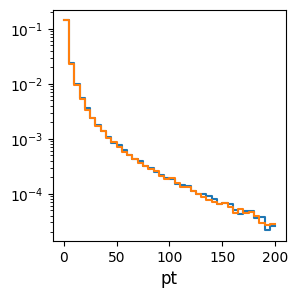

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
gen_sample.histplot(
    feature="pt", fill=False, log_scale=(False, True), ax=ax, stat="density", binrange=(0, 200), binwidth=5
)  # momentum distrbution

jets.target.histplot(
    feature="pt", fill=False, log_scale=(False, True), ax=ax, stat="density", binrange=(0, 200), binwidth=5
)  # momentum distrbution
plt.show()


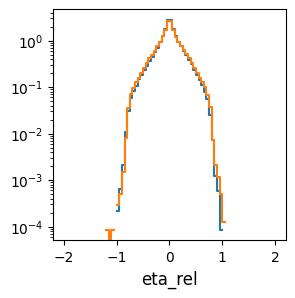

In [7]:

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
gen_sample.histplot(
    feature="eta_rel", fill=False, log_scale=(False, True), ax=ax, stat="density", binrange=(-2, 2), binwidth=0.05
)  # momentum distrbution

jets.target.histplot(
    feature="eta_rel", fill=False, log_scale=(False, True), ax=ax, stat="density", binrange=(-2,2), binwidth=0.05
)  # momentum distrbution
plt.show()